# Student SAT scores

This project is about finding drivers for student SAT scores in the US. Several different data sets are put together to create a data set that can be analyzed to see if we can identify any correlations between the SAT scores and any of the variables. The data is contained in five csv files downloaded from local authorities in New York city as well as the results of two surveys. While we are working on the data we will work from a dictionary containing the different data files until we are ready to create a dataframe with the combined data.

In [1]:
# Import libraries
import pandas as pd
import numpy
import re
# Create a dictionary with the different data files
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys
Along with demographic and descriptive data from local school authorities, we have survey data we can use.

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Data cleaning and transformation
Add a DBN column where to the data which is an ID number containing the class size and school code. This will help create a key we can use with the survey data.

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert columns to numeric
Some of the data is in string format and needs to be converted to numeric.

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [15]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

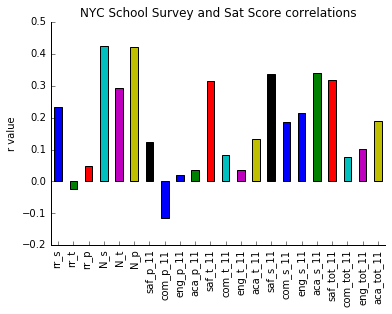

In [48]:
# Plot the correlations of the NYC school survey
import matplotlib.pyplot as plt
%matplotlib inline

ax = correlations[survey_fields].plot.bar()
plt.title('NYC School Survey and Sat Score correlations')
plt.ylabel('r value')
plt.tick_params(top='off', right='off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.show()

There are several interesting correlations. Overall, responses from students correlate well to the sat scores, particularly safety (saf) and academic expectations (aca) which both have an r value of over 0.3. Surprising is how low the parents responses correlate, particularly the slight negative correlation of communication (comm). Teachers also have low correlations in most of their responses with the exception of safety with is also over 0.3. It would appear that safety and academic expectations are the most important factors by far.

We will investigate the safety scores further.

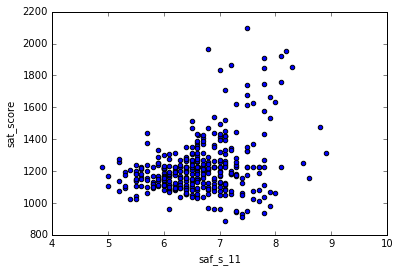

In [51]:
# Plot student safety score and the sat score
combined.plot.scatter('saf_s_11', 'sat_score')

Once the safety score goes over 6.5 we can see a strong positive correlation. There are a few data points below 1000 with a high safetey score which may be the international schools. A safety score between 7 and 8 seems to account for the widest variety of test scores and the highest scores.

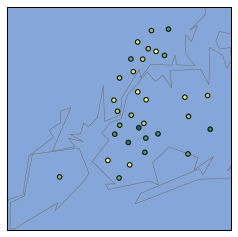

In [61]:
# Map the average safety score by district.
# Create dataframe of averages
districts = combined.groupby('school_dist').agg(numpy.mean)
# Create map to plot average safety scores on
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc',
    llcrnrlat=40.496044,
    urcrnrlat=40.915256,
    llcrnrlon=-74.255735,
    urcrnrlon=-73.700272, 
    resolution='i')
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
# Cast coordinates to a list and pass into the plot
longitude = districts['lon'].tolist()
latitude = districts['lat'].tolist()
m.scatter(longitude, 
          latitude, 
          s=20, 
          zorder=2, 
          latlon=True, 
          c=districts['saf_s_11'], 
          cmap='summer')

Manhattan seems to have a mix of schools with high and low safety scores. Brooklyn, however, has a lot of schools with low safety scores. Queens also has a mix but seems to have safer schools in general.

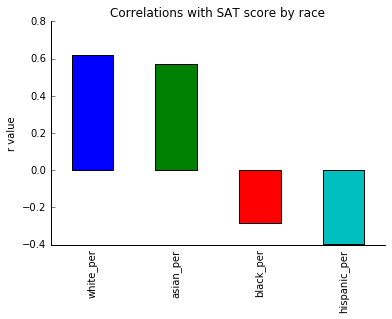

In [82]:
ax2 = correlations[['white_per', 'asian_per', 'black_per', 'hispanic_per']].plot.bar()
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(top='off', right='off', bottom='off')
ax2.set_title('Correlations with SAT score by race')
ax2.set_ylabel('r value')

There is a clear difference between the correlations of Asians and Whites vs Blacks and Hispanics. This is inline with the data from the map showing areas with high diversity (higher numbers of Black and Hispanic students in the schools) have lower safety scores which correlate to lower SAT scores.

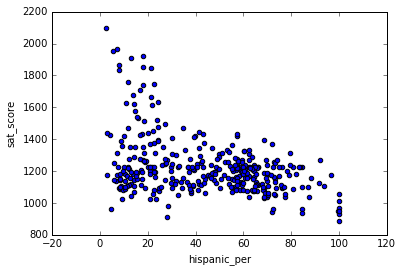

In [84]:
# Plot the correlation between density of hispanic students
# and SAT score of schools
combined.plot.scatter('hispanic_per', 'sat_score')

We can see a clear negative correlation between the number of hispanic students in a school and SAT scores.

In [90]:
# Schools with most Hispanic students
combined['School Name'].loc[combined['hispanic_per'] > 95]

44             MANHATTAN BRIDGES HIGH SCHOOL
82                                         0
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIE
125                                        0
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object

In [96]:
# Schools with fewest hispanic students and high test scores 
combined['School Name'].loc[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]

37                    STUYVESANT HIGH SCHOOL
151             BRONX HIGH SCHOOL OF SCIENCE
187           BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES A
356      STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: School Name, dtype: object

Looking at the schools with the most hispanic students and the top performing schools with the least hispanic students we get a bit clearer picture. The schools themselves are located in different buroughs which means location isn't the best predictor as we saw with mixed safety scores on the map. However, the schools with the most hispanic students tend to be multicultural schools targeted at people with low skill sets and diverse backgrounds. They generally have lower test scores while the schools with the lowest number of hispanic students are some of the most elite schools in New York.

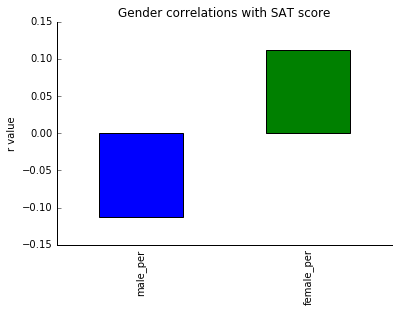

In [104]:
# Plot gender correlations
ax3 = correlations[['male_per', 'female_per']].plot.bar()
ax3.set_title('Gender correlations with SAT score')
ax3.set_ylabel('r value')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.tick_params(top='off', right='off', bottom='off')

Overall, the correlations between gender and SAT score are not very strong but there is a minor negative correlation between males and SAT score and a minor posive correlation between females and SAT score.

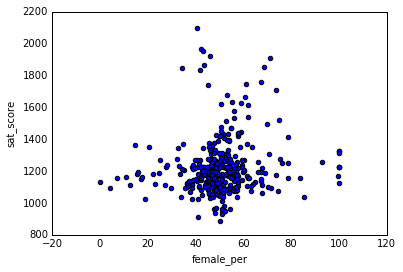

In [107]:
# Plot female students and SAT score
combined.plot.scatter(x='female_per', y='sat_score')
plt.tick_params(top='off', right='off', left='off', bottom='off')

There is a slight correlation for females but it may be getting skewed by some outlighers. It appears there are some schools that are entirely or almost entirely female.

In [108]:
# Top performing schools with high ratio of females
combined['School Name'].loc[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]

5            BARD HIGH SCHOOL EARLY COLLEGE
26            ELEANOR ROOSEVELT HIGH SCHOOL
60                       BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF
302             TOWNSEND HARRIS HIGH SCHOOL
Name: School Name, dtype: object

A quick look at the top scoring 5 schools shows they are extremely elite schools, although none of them are 'all-girls' schools. It appears, generally speaking girls may be outperforming boys on the SAT.

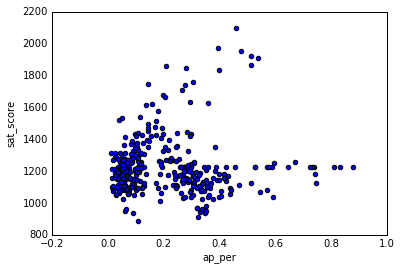

In [114]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined.plot.scatter(x='ap_per', y='sat_score')
plt.tick_params(top=False, right=False, left=False, bottom=False)

The scatter plot shows two large clusters which don't appear to have a strong relationship with AP tests but there are some data points above which are more dispersed. They appear to have a strong correlation with taking AP tests. However, the highest percentages of AP test takers do not have scores above 1200.